In [1]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('/Users/reginakuszajewski/Downloads/datakit_farmers.parquet')

In [10]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
import regex as re

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/reginakuszajewski/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/reginakuszajewski/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reginakuszajewski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/reginakuszajewski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/reginakuszajewski/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
def preprocessing_steps(text):
    standard_txt = text.lower()
    # remove multiple white spaces and line breaks
    clean_txt = re.sub(r'\n', ' ', standard_txt)
    clean_txt = re.sub(r'\s+', ' ', clean_txt)
    clean_txt = clean_txt.strip()
    extra_stop_words = ['q', 'e', 'j', 'go', 'get']
    stop_words = set(nltk.corpus.stopwords.words('english')) | set(extra_stop_words)
    nan = 'nan'
    # tokenize text
    tokens = nltk.word_tokenize(clean_txt)
    # remove non-alphabetic tokens
    filtered_tokens_alpha = [word for word in tokens if word.isalpha() and not re.match(r'^[ivxlcdm]+$', word.lower())]
    #remove stop words
    no_null_text = [word for word in filtered_tokens_alpha if word != nan]
    final_text = [word for word in no_null_text if word not in stop_words]
    return final_text

In [4]:
df.head()

,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,...,question_user_country_code,question_user_gender,question_user_dob,question_user_created_at,response_user_type,response_user_status,response_user_country_code,response_user_gender,response_user_dob,response_user_created_at
0,3849056,519124,nyn,E ABA WEFARM OFFICES ZABO NIZISHANGWA NKAHI?,None,2017-11-22 12:25:03+00,20691011,200868,nyn,E!23 Omubazi Ni Dudu Cipa',...,ug,None,None,2017-11-18 13:09:11+00,farmer,live,ug,None,None,2017-05-09 09:19:33+00
1,3849061,521327,eng,Q this goes to wefarm. is it possible to get f...,None,2017-11-22 12:25:05+00,4334249,526113,eng,Q1 which stage is marleks last vaccinated,...,ug,None,None,2017-11-20 11:55:48+00,farmer,zombie,ug,None,None,2017-11-22 10:13:03+00
2,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cattle,2017-11-22 12:25:08+00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,...,ug,None,None,2017-08-22 14:51:07+00,farmer,zombie,ug,None,None,2017-08-12 09:30:33+00
3,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cattle,2017-11-22 12:25:08+00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,...,ug,None,None,2017-08-22 14:51:07+00,farmer,zombie,ug,None,None,2017-08-12 09:30:33+00
4,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cat,2017-11-22 12:25:08+00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,...,ug,None,None,2017-08-22 14:51:07+00,farmer,zombie,ug,None,None,2017-08-12 09:30:33+00


In [27]:
columns_wanted = ['question_content', 'question_user_country_code', 'question_sent', 'question_topic', 'question_language']
ug_df = df[columns_wanted]
ug_df = ug_df[ug_df['question_user_country_code'] == 'ug'] #I want to focus just on Ugandan farmers
ug_df = ug_df.drop_duplicates().dropna()

In [28]:
ug_df = ug_df.drop_duplicates(subset = 'question_content') #dropping more duplicates because some are spam that mess everything up

In [29]:
ug_df['question_language'].value_counts()

question_language
eng    851256
nyn    222717
lug    145583
Name: count, dtype: int64

In [30]:
eng_qs = ug_df[ug_df['question_language'] == 'eng']

In [31]:
eng_qs['cleaned_tokens'] = eng_qs['question_content'].apply(preprocessing_steps)

/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/2207276115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_qs['cleaned_tokens'] = eng_qs['question_content'].apply(preprocessing_steps)


In [32]:
print(eng_qs[['cleaned_tokens', 'question_content']].head())

                                       cleaned_tokens  \
15                          [start, aproject, poutry]   
26  [jackson, ibanda, want, grow, tomatoes, alarge...   
39                         [manage, coffee, diseases]   
43                  [raise, coffee, plants, seedling]   
64              [medicine, given, pigs, swine, fever]   

                                     question_content  
15  Q J Have Mi 10000 Can J Start Aproject Of Pout...  
26  Q Am Jackson From Ibanda If Want To Grow Tomat...  
39           how can i manage my coffee from diseases  
43       how can i raise coffee plants from seedling?  
64  WHICH MEDICINE CAN BE GIVEN TO PIGS WITH SWINE...  


In [33]:
topics_keywords = {
    "Planting / Crops": ["seed", "seeds", "sow", "germinate", "plant", "crop", "variety", "spacing", "soil preparation", "planting"],
    "Harvest / Post-Harvest": ["harvest", "yield", "pick", "collect", "storage", "preservation", "drying", "transport", "milling"],
    "Pests / Diseases / Soil": ["pest", "disease", "insect", "fungus", "soil", "nutrient", "fertilizer", "organic", "compost", "infection"],
    "Irrigation / Water": ["water", "irrigation", "drip", "sprinkler", "rainfall", "drought", "moisture", "flood"],
    "Livestock / Animal Husbandry": ["feed", "nutrition", "breeding", "vaccination", "health", "housing", "cow", "chicken", "animal"],
    "Markets / Economics": ["market", "price", "demand", "sell", "buy", "profit", "export", "income", "cooperative"],
    "Technology / Equipment": ["tractor", "harvester", "machine", "tool", "app", "sensor", "automation", "equipment"],
    "Policy / Finance": ["subsidy", "loan", "insurance", "government", "certification", "organic", "policy", "regulation"]
}

In [34]:
def assign_topics(question):
    question_lower = question.lower()
    matched_topics = []
    for topic, keywords in topics_keywords.items():
        for kw in keywords:
            # Use word boundaries to avoid partial matches
            if re.search(r'\b' + re.escape(kw) + r'\b', question_lower):
                matched_topics.append(topic)
                break  # stop after first keyword match per topic
    if not matched_topics:
        matched_topics = ["Misc / Other"]
    return "; ".join(matched_topics)

In [35]:
eng_qs['question_type'] = eng_qs['cleaned_tokens'].astype(str).apply(assign_topics)

/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/1146577185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_qs['question_type'] = eng_qs['cleaned_tokens'].astype(str).apply(assign_topics)


In [50]:
eng_qs['question_type'].value_counts()

question_type
Livestock / Animal Husbandry                                                                                         415849
Planting / Crops                                                                                                     197961
Pests / Diseases / Soil                                                                                              117001
Markets / Economics                                                                                                   56737
Misc / Other                                                                                                          17186
                                                                                                                      ...  
Irrigation / Water; Markets / Economics; Technology / Equipment                                                           1
Technology / Equipment; Policy / Finance                                                                              

In [49]:
topic_counts = (
    eng_qs.groupby(['question_type'])
      .size()
      .reset_index(name='count')
)

top10 = (
    topic_counts
    .sort_values(['count'], ascending=False)
    .head(10)
)

In [51]:
top10



,question_type,count
23,Livestock / Animal Husbandry,415849
48,Planting / Crops,197961
33,Pests / Diseases / Soil,117001
29,Markets / Economics,56737
32,Misc / Other,17186
0,Harvest / Post-Harvest,13113
16,Irrigation / Water,8575
70,Planting / Crops; Pests / Diseases / Soil,5549
67,Planting / Crops; Markets / Economics,3631
60,Planting / Crops; Irrigation / Water,2851


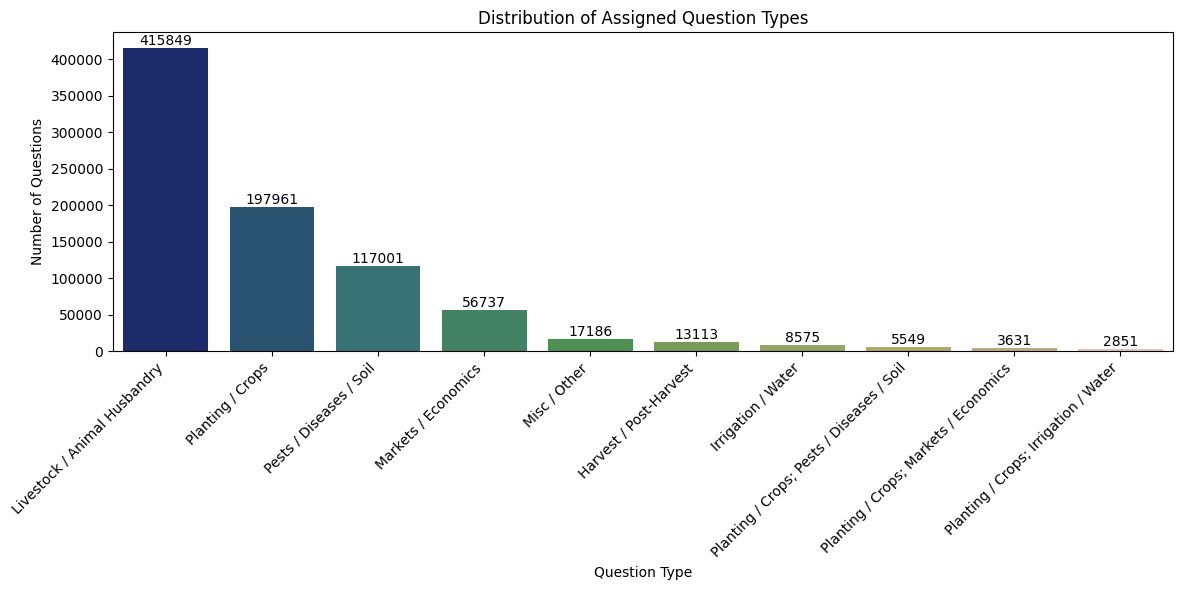

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

sns.barplot(
    data=top10,
    x='question_type',
    y='count',
    hue = 'question_type',
    palette='gist_earth')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Questions")
plt.xlabel("Question Type")
plt.title("Distribution of Assigned Question Types")

# Optional: add counts on top of bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width()/2., height + 0.5),  # adjust offset
        ha='center',
        va='bottom'
    )
plt.tight_layout()
plt.savefig('plot4.png')
plt.show()


In [37]:
misc_df = eng_qs[eng_qs['question_type'] == 'Misc / Other']
misc_texts = misc_df['cleaned_tokens'].tolist()
misc_df['cleaned_text'] = misc_df['cleaned_tokens'].apply(lambda toks: " ".join(toks))
misc_texts = misc_df['cleaned_text'].tolist()

/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/3860226040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misc_df['cleaned_text'] = misc_df['cleaned_tokens'].apply(lambda toks: " ".join(toks))


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.6,
    ngram_range=(1,2),
    stop_words='english'
)

X = tfidf.fit_transform(misc_texts)

In [39]:
from sklearn.cluster import MiniBatchKMeans

k = 10
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=2048, random_state=42)
labels = kmeans.fit_predict(X)

In [40]:
import numpy as np

terms = tfidf.get_feature_names_out()

for i in range(k):
    print(f"\nCluster {i} top terms:")
    center = kmeans.cluster_centers_[i]
    top_idx = center.argsort()[-15:][::-1]
    print([terms[i] for i in top_idx])


Cluster 0 top terms:
['use', 'spray', 'use spray', 'tomatoes', 'chemical', 'medicine use', 'medicine', 'chemical use', 'spray tomatoes', 'type', 'beans', 'used spray', 'use treat', 'use control', 'drug']

Cluster 1 top terms:
['causes', 'tomato', 'leaves', 'animals', 'wat causes', 'tomato garden', 'garden', 'cattle', 'bright', 'wat', 'type tomato', 'tomatoes', 'plants', 'tomato bright', 'blight']

Cluster 2 top terms:
['maize', 'kg', 'kg maize', 'grow', 'maize garden', 'type maize', 'garden', 'grow maize', 'cost', 'type', 'control', 'cost maize', 'hw', 'good', 'maize grow']

Cluster 3 top terms:
['pig', 'tomatoes', 'pigs', 'grow', 'coffee', 'beans', 'long', 'hens', 'hw', 'good', 'animals', 'cattle', 'type', 'hen', 'goat']

Cluster 4 top terms:
['passion', 'passion fruits', 'fruits', 'passion fruit', 'fruit', 'spray passion', 'grow passion', 'long passion', 'use', 'grow', 'spray', 'long', 'growing passion', 'flowers', 'sack passion']

Cluster 5 top terms:
['crops', 'grow', 'crops grow'

In [41]:
misc_df['misc_cluster'] = labels
misc_df['misc_cluster'].value_counts()

/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/3489489051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misc_df['misc_cluster'] = labels


misc_cluster
3    349084
2     34766
0     33163
7     26916
6     24758
1     24068
9     17587
8     17186
5     13156
4      7576
Name: count, dtype: int64

In [46]:
# Mapping clusters to main topics
cluster_to_main_topic = {
    0: "Pests / Diseases / Soil",
    1: "Pests / Diseases / Soil",
    2: "Planting / Crops",
    3: "Livestock / Animal Husbandry",  
    4: "Planting / Crops",
    5: "Planting / Crops",
    6: "Pests / Diseases / Soil",
    7: "Planting / Crops",
    8: "Misc / Other",
    9: "Livestock / Animal Husbandry"
}

misc_df['main_topic'] = misc_df['misc_cluster'].map(cluster_to_main_topic)


/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/2607764628.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misc_df['main_topic'] = misc_df['misc_cluster'].map(cluster_to_main_topic)


In [47]:
misc_df['main_topic'].value_counts()

main_topic
Livestock / Animal Husbandry    366671
Planting / Crops                 82414
Pests / Diseases / Soil          81989
Misc / Other                     17186
Name: count, dtype: int64

In [48]:
# Merge back to main dataframe
eng_qs.loc[eng_qs['question_type']=='Misc / Other','question_type'] = misc_df['main_topic'].values

In [53]:
eng_qs['question_sent'] = pd.to_datetime(eng_qs['question_sent'], infer_datetime_format=True, format = 'mixed')

/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/2557344351.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  eng_qs['question_sent'] = pd.to_datetime(eng_qs['question_sent'], infer_datetime_format=True, format = 'mixed')
/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/2557344351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_qs['question_sent'] = pd.to_datetime(eng_qs['question_sent'], infer_datetime_format=True, format = 'mixed')


In [54]:
eng_qs['month'] = eng_qs['question_sent'].dt.month
eng_qs['year'] = eng_qs['question_sent'].dt.year

def uganda_season(m):
    if m in [3,4,5]:
        return "Season A Planting (March-May)"
    elif m in [6, 7,8]:
        return "Season A Harvesting (June-August)"
    elif m in [9,10,11]:
        return "Season B Planting (September-November)"
    else:
        return "Season B Harvesting (December-February)"

eng_qs['season'] = eng_qs['month'].apply(uganda_season)

/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/2353776506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_qs['month'] = eng_qs['question_sent'].dt.month
/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/2353776506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_qs['year'] = eng_qs['question_sent'].dt.year
/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/2353776506.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [55]:
season_topic_counts = (
    eng_qs.groupby(['season','question_type'])
          .size()
          .reset_index(name='count')
        .sort_values(['count'], ascending=False)
        .head(20)
)

season_topic_counts.sort_values(['season','count'], ascending=[True, False], inplace=True)
season_topic_counts.head(10)

,season,question_type,count
19,Season A Harvesting (June-August),Livestock / Animal Husbandry,112000
40,Season A Harvesting (June-August),Planting / Crops,52926
28,Season A Harvesting (June-August),Pests / Diseases / Soil,30722
24,Season A Harvesting (June-August),Markets / Economics,16056
27,Season A Harvesting (June-August),Misc / Other,4125
88,Season A Planting (March-May),Livestock / Animal Husbandry,93887
108,Season A Planting (March-May),Planting / Crops,46979
96,Season A Planting (March-May),Pests / Diseases / Soil,26995
92,Season A Planting (March-May),Markets / Economics,10756
150,Season B Harvesting (December-February),Livestock / Animal Husbandry,92912


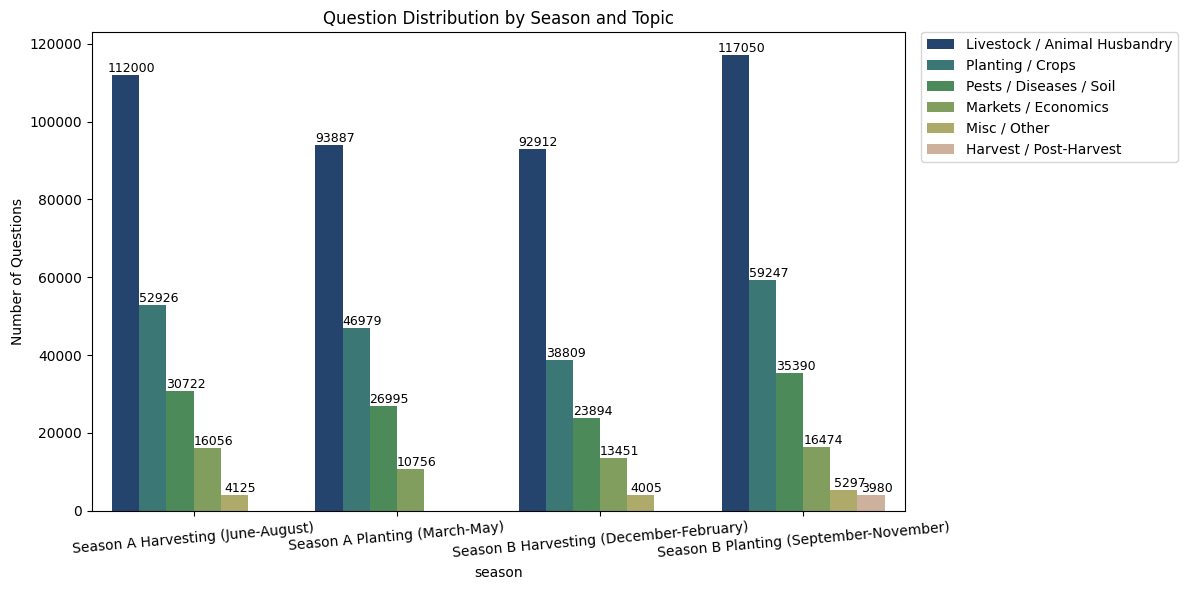

In [56]:
import seaborn as sns

plt.figure(figsize=(12,6))
ax = sns.barplot(data=season_topic_counts, x='season', y='count', hue='question_type', palette = 'gist_earth')
plt.xticks(rotation=5)
plt.ylabel("Number of Questions")
plt.title("Question Distribution by Season and Topic")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
offset_x = 0.03  

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{int(height)}',
            (p.get_x() + p.get_width() / 2. + offset_x, height),  
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.savefig('plot3.png')
plt.show()

In [57]:
topic_year_month = (
    eng_qs.groupby(['year','month','question_type'])
      .size()
      .reset_index(name='count')
)
top5 = (
    topic_year_month
        .groupby("question_type")["count"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .index.tolist()
)

topic_year_month["z"] = (
    topic_year_month.groupby("question_type")["count"]
    .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
)

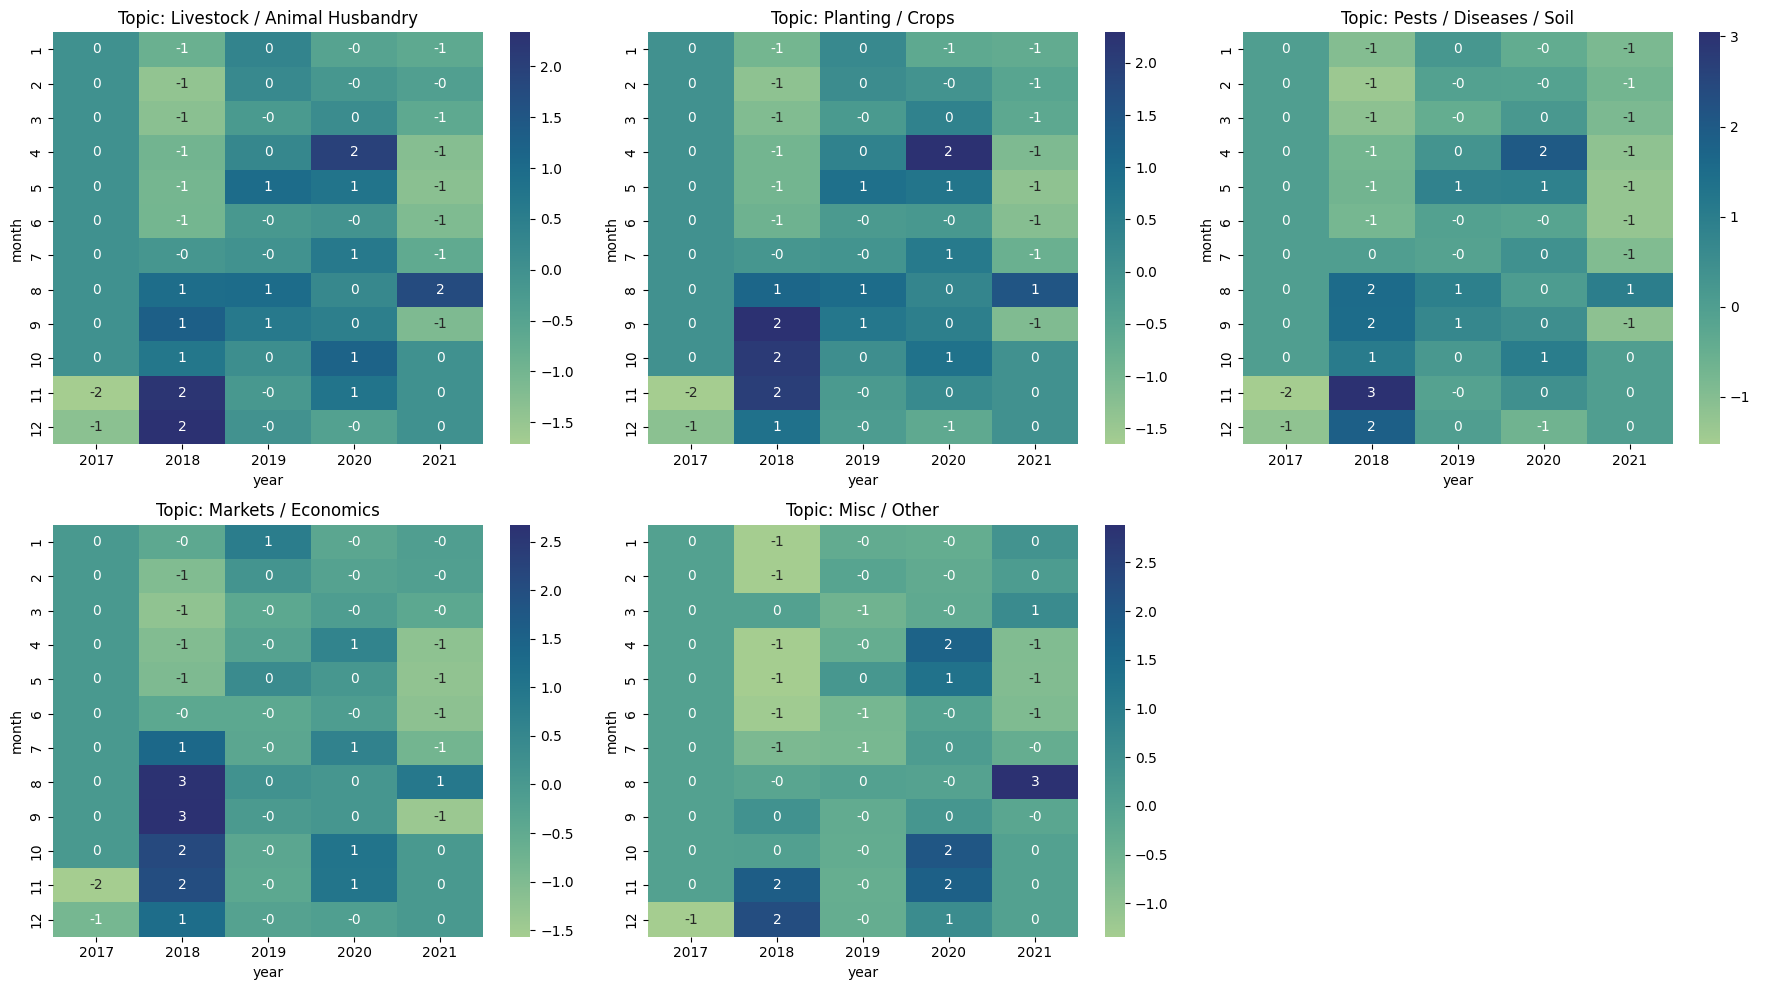

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes = axes.flatten()

for i, topic in enumerate(top5):
    tm = topic_year_month[topic_year_month['question_type'] == topic]
    pivot = tm.pivot(index="month", columns="year", values="z").fillna(0)

    sns.heatmap(
        pivot,
        ax=axes[i],
        annot=True,
        fmt=".0f",
        cmap="crest"
    )
    axes[i].set_title(f"Topic: {topic}")

# Turn off the unused 6th subplot
axes[-1].axis("off")

plt.tight_layout()
plt.savefig('plot2.png')
plt.show()

In [59]:
crop_keywords = ['coffee', 'maize', 'beans', 'cassava', 'banana', 'tomato', 'crop', 'planting', 'harvest']
animal_keywords = ['pig', 'pigs', 'cattle', 'goat', 'goats', 'chicken', 'hens', 'poultry', 'livestock']

def correct_topic(row):
    text = row['cleaned_tokens']
    if row['question_type'] == 'Livestock / Animal Husbandry':
        if any(word in text for word in crop_keywords):
            return 'Planting / Crops'
    # if assigned to crops but mentions animals, fix
    elif row['question_type'] == 'Planting / Crops':
        if any(word in text for word in animal_keywords):
            return 'Livestock / Animal Husbandry'
    return row['question_type']

eng_qs['question_type'] = eng_qs.apply(correct_topic, axis=1)


/var/folders/zn/cnbb8tdj24g_h7k2_x0gxqwc0000gq/T/ipykernel_9182/159719251.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_qs['question_type'] = eng_qs.apply(correct_topic, axis=1)


In [60]:
eng_qs['question_type'].value_counts()

question_type
Livestock / Animal Husbandry                                                                                         378648
Planting / Crops                                                                                                     235162
Pests / Diseases / Soil                                                                                              117001
Markets / Economics                                                                                                   56737
Misc / Other                                                                                                          17186
                                                                                                                      ...  
Irrigation / Water; Markets / Economics; Technology / Equipment                                                           1
Technology / Equipment; Policy / Finance                                                                              

In [61]:
topic_year_month["date"] = pd.to_datetime(
    topic_year_month["year"].astype(str) + "-" +
    topic_year_month["month"].astype(str).str.zfill(2)
)

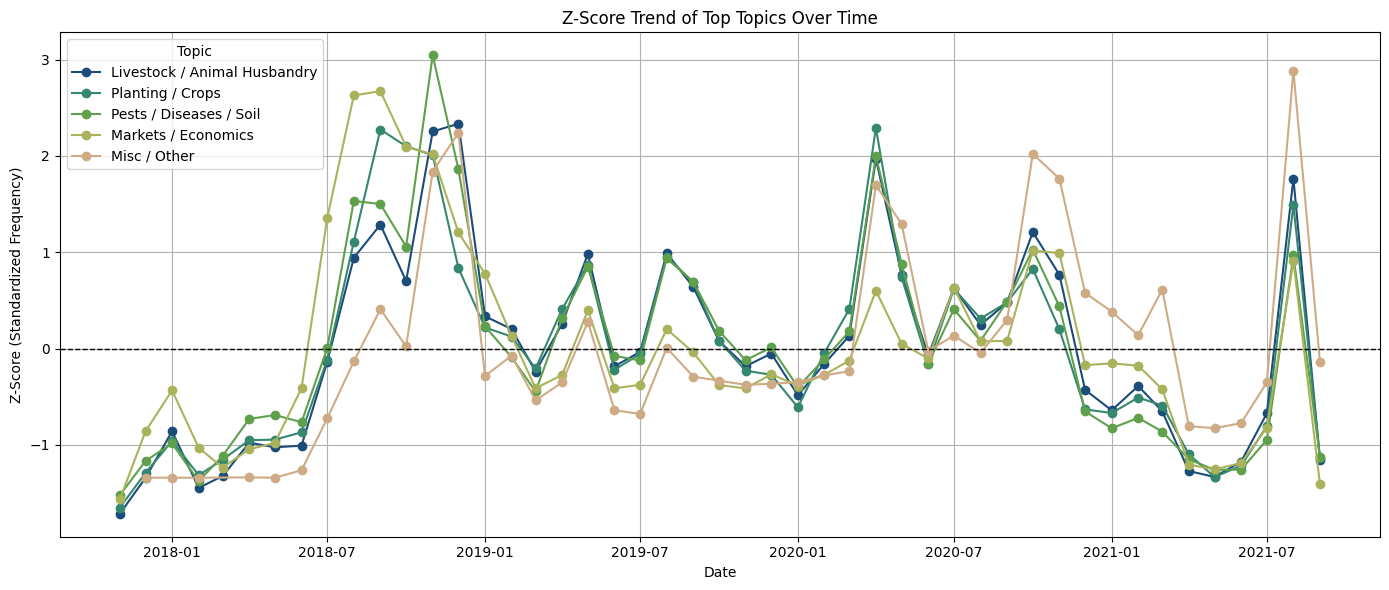

In [62]:
colors = sns.color_palette("gist_earth", n_colors=len(top5))

plt.figure(figsize=(14, 6))

for i, topic in enumerate(top5):
    subset = topic_year_month[topic_year_month["question_type"] == topic]
    plt.plot(subset["date"], subset["z"], marker='o', label=topic, color = colors[i])

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title("Z-Score Trend of Top Topics Over Time")
plt.xlabel("Date")
plt.ylabel("Z-Score (Standardized Frequency)")
plt.legend(title="Topic")
plt.grid(True)

plt.tight_layout()
plt.savefig('plot1.png')
plt.show()